In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/'My Drive'/'CS 247'/'Project'
%ls

Mounted at /content/drive
/content/drive/My Drive/CS 247/Project
deeplog.ipynb  deeplog_mlm.ipynb  LINE_GMM.ipynb  loglizer/  nulog/


In [2]:
%cd loglizer
from loglizer import dataloader, preprocessing

/content/drive/My Drive/CS 247/Project/loglizer


In [3]:
#struct_log = '../MyData/' # The structured log file
#label_file = '../MyData/anomaly_label.csv' # The anomaly label file
curr_path = "/content/drive/My Drive/CS 247/Project/loglizer"
#struct_log = '/content/drive/MyDrive/CS 247/Project/loglizer/data/HDFS/HDFS.npz'
struct_log = '/content/drive/MyDrive/CS 247/Project/loglizer/data/HDFS/HDFS_100k.log_structured.csv'
label_file = '/content/drive/MyDrive/CS 247/Project/loglizer/data/HDFS/anomaly_label.csv' # The anomaly label file

In [4]:
train_ratio = 0.5

In [5]:
(X_train, y_train), (X_test, y_test), df = dataloader.load_HDFS(struct_log,
                                                            label_file=label_file,
                                                            window='session', 
                                                            train_ratio=train_ratio,
                                                            split_type='uniform')

====== Input data summary ======
Loading /content/drive/MyDrive/CS 247/Project/loglizer/data/HDFS/HDFS_100k.log_structured.csv
156 157
Total: 7940 instances, 313 anomaly, 7627 normal
Train: 3969 instances, 156 anomaly, 3813 normal
Test: 3971 instances, 157 anomaly, 3814 normal



In [29]:
# import necessary libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import trange 
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sb
import networkx as nx
import numpy as np
from scipy.linalg import sqrtm 
from numpy import linalg as LA

import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report

In [7]:
class Embedding(nn.Module):
    def __init__(self, size, embed_dim=8):
        super(Embedding, self).__init__()

        self.embed_dim = embed_dim
        self.nodes_embeddings = nn.Embedding(size, embed_dim)

        # Initialization
        self.nodes_embeddings.weight.data = self.nodes_embeddings.weight.data.uniform_(-.5, .5) / embed_dim

    def loss(self, v_i, v_j, negsamples):
        
        v_i = self.nodes_embeddings(v_i) 
        v_j = self.nodes_embeddings(v_j) 
        negsamples = -1 * self.nodes_embeddings(negsamples)
        pos_pair_loss = torch.mul(v_i, v_j) 
        pos_pair_loss = F.logsigmoid(torch.sum(pos_pair_loss, dim=1)) 

        neg_pair_loss = torch.mul(v_i.view(-1, 1, self.embed_dim), negsamples)
        neg_pair_loss = torch.sum(neg_pair_loss, dim=2) 
        neg_pair_loss = torch.sum(F.logsigmoid(neg_pair_loss),dim=1) 
        
        contrastive_loss = pos_pair_loss + neg_pair_loss 

        return torch.mean(contrastive_loss) * -1
        

In [8]:
#     generating batches of data.

def makeData(samplededges, negsamplesize, degree):
    sampledNodes = set()
    nodesProb = []
    sumofDegree = 0
    for e in samplededges:
        sampledNodes.add(e[0])
        sampledNodes.add(e[1])
    sampledNodes = list(sampledNodes)
    nodesProb = [pow(degree[v],3/4) for v in sampledNodes]
    sumofDegree = sum(nodesProb)
    nodesProb[:] = [x/sumofDegree for x in nodesProb]

    for e in samplededges:
        sourcenode, targetnode = e[0], e[1]
        negnodes = []
        negsamples = 0
        while negsamples < negsamplesize:
            samplednode = np.random.choice(sampledNodes, p = nodesProb)
            
            if (samplednode == sourcenode) or (samplednode == targetnode):
                continue
            else:
                negsamples += 1
                negnodes += [samplednode]
        yield [e[0], e[1]] + negnodes

        


In [9]:
def get_degree(X_train, window_size):
  nodes = set()
  nodes_d = {}
  for seq in X_train:
    if window_size == 1:
      for event in seq:
        nodes.add(event)
        nodes_d[event] = nodes_d.get(event, 0) + 1
    else:
      m = len(seq)
      for i in range(m+1 - window_size):
        event = tuple(seq[i:i+window_size])
        nodes.add(event)
        nodes_d[event] = nodes_d.get(event, 0) + 1
  return nodes_d 

def create_edges(samples):
  edges = []
  for seq in samples:
    m = len(seq)
    for i in range(m-1):
      edges.append([seq[i], seq[i+1]])
  return edges

#### Train

In [10]:
degree = get_degree(X_train, window_size= 1)

In [11]:
node_to_ind = {x:i for i,x in enumerate(degree.keys())}

In [37]:
def train(X_train, degree, node_to_ind, 
          n_epochs = 100, neg_size = 3, n_batches = 3, batch_size = 10):
  
  # training

  embed = Embedding(len(degree), embed_dim=8)
  opt = optim.Adam(embed.parameters())
  
  for epoch in range(n_epochs):
      for b in trange(n_batches):
          opt.zero_grad()
          edge_idx = np.random.choice(len(X_train), batch_size)
          samplededges = create_edges(X_train[edge_idx])
          
          batch = list(makeData(samplededges, neg_size, degree))
          recoded_batch = []
          for seq in batch:
            recoded_batch.append([node_to_ind[e] for e in seq])

          batch = torch.LongTensor(recoded_batch)
          
          # based on the generated batch, train LINE via minimizing the loss.
          v_i = batch[:,0]
          v_j = batch[:,1]
          negsamples =  batch[:,2:]
          loss = embed.loss(v_i, v_j, negsamples)
          loss.backward()
          opt.step()

  # TSNE visualization, with node id on
  event_emb  = embed.nodes_embeddings.weight.data.numpy()

  train_emb = np.zeros((X_train.shape[0], event_emb.shape[1]))
  for i,seq in enumerate(X_train):
    translated_seq = [node_to_ind[e] for e in seq]
    for ind in translated_seq:
      #print(ind)
      train_emb[i] += event_emb[ind]

  return event_emb, train_emb


def fit_pred(train_emb, event_emb, y_train, X_test, y_test, node_to_ind, n_clusters = 4, plot = False):
  gm = GaussianMixture(n_components=n_clusters, random_state=0).fit(train_emb)
  train_preds = []

  for emb in train_emb:
    train_preds.append(gm.predict(emb.reshape(1, -1)))

  train_preds = np.array(train_preds)

  c_labels = []
  for i in range(n_clusters):
    cluster_ones = np.sum(y_train[(train_preds == i).ravel()])
    cluster_size = np.sum(train_preds == i)
    c_labels.append(round(cluster_ones/cluster_size))
    #print(i, sum(train_preds == i), np.sum(y_train[(train_preds == i).ravel()]))
  
  test_emb = np.zeros((X_test.shape[0], event_emb.shape[1]))
  for i,seq in enumerate(X_test):
    translated_seq = []
    for e in seq:
      if e in node_to_ind:
        translated_seq.append(node_to_ind[e])
    for ind in translated_seq:
      test_emb[i] += event_emb[ind]

  if plot:
    tsne_emb = TSNE(n_components = 2, perplexity = 5, learning_rate = 10).fit_transform(test_emb)

    plt.scatter(tsne_emb[:,0], tsne_emb[:,1])
    for i in range(len(tsne_emb)):
        plt.annotate(str(i), xy=(tsne_emb[i,0], tsne_emb[i,1]))
    plt.show()


  test_pred = []
  test_min_dists = []
  for emb in test_emb:
    dists = (emb - gm.means_)
    dists = np.apply_along_axis(np.linalg.norm, 1, dists)
    test_min_dists.append(np.min(dists))
    test_pred.append(c_labels[gm.predict(emb[np.newaxis, :])[0]])

  print(classification_report(y_test, test_pred))
      

In [19]:
event_emb, train_emb = train(X_train, degree, node_to_ind, \
          n_epochs = 100, neg_size = 3, n_batches = 3, batch_size = 10)

100%|██████████| 3/3 [00:00<00:00, 46.30it/s]


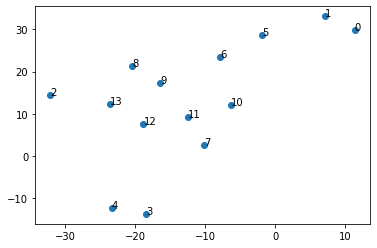

In [20]:
# TSNE visualization, with node id on
tsne_emb = TSNE(n_components = 2, perplexity = 5, learning_rate = 10).fit_transform(event_emb)

plt.scatter(tsne_emb[:,0], tsne_emb[:,1])
for i in range(len(tsne_emb)):
    plt.annotate(str(i), xy=(tsne_emb[i,0], tsne_emb[i,1]))
plt.show()



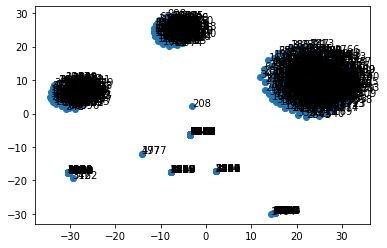

In [21]:
tsne_emb = TSNE(n_components = 2, perplexity = 5, learning_rate = 10).fit_transform(train_emb)

plt.scatter(tsne_emb[:,0], tsne_emb[:,1])
for i in range(len(tsne_emb)):
   plt.annotate(str(i), xy=(tsne_emb[i,0], tsne_emb[i,1]))
plt.show()



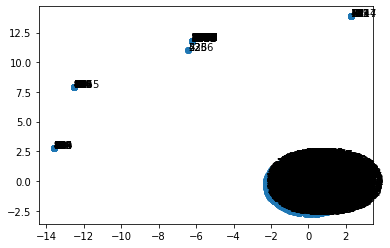

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3814
           1       0.99      0.43      0.60       157

    accuracy                           0.98      3971
   macro avg       0.98      0.71      0.79      3971
weighted avg       0.98      0.98      0.97      3971



In [38]:
fit_pred(train_emb, event_emb, y_train, X_test, y_test, node_to_ind, n_clusters, True)

In [36]:
fit_pred(train_emb, event_emb, y_train, X_test, y_test, node_to_ind, n_clusters)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3814
           1       0.99      0.43      0.60       157

    accuracy                           0.98      3971
   macro avg       0.98      0.71      0.79      3971
weighted avg       0.98      0.98      0.97      3971



In [ ]:
test_pred = []
test_min_dists = []
for emb in test_emb:
  dists = (emb - gm.means_)
  dists = np.apply_along_axis(np.linalg.norm, 1, dists)
  test_min_dists.append(np.min(dists))
  test_pred.append(c_labels[gm.predict(emb[np.newaxis, :])[0]])



### MLM embedding

In [ ]:
# import necessary libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import trange 
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sb
import networkx as nx
import numpy as np
from scipy.linalg import sqrtm 
from numpy import linalg as LA
from logparser.NuLog import NuLogParser
from logparser.utils import evaluator
from tqdm import trange 

filters = '(\s+blk_)|(:)|(\s)'
log_format = '<Date> <Time> <Pid> <Level> <Component>: <Content>'

# parser = NuLogParser.LogParser(indir='logs/', outdir=None, filters=filters, k=15, log_format=log_format)
# parser.logName = 'HDFS/HDFS_2k.log'
# parser.mask_percentage = 1
# parser.pad_len = 150
# parser.num_samples = 0
# parser.batch_size = 5

parser = NuLogParser.LogParser(indir='logs/', outdir=None, filters=filters, k=15, log_format=log_format)
parser.logName = 'HDFS/HDFS_2k.log'
parser.mask_percentage = 1
parser.pad_len = 150
parser.num_samples = 0
parser.batch_size = 5
parser.step_size=10

parser.load_data()

df_len = parser.df_log.shape[0]
data_tokenized = []

for i in trange(0, df_len):
  tokenized = parser.tokenizer.tokenize('<CLS> ' + parser.df_log.iloc[i].Content)
  data_tokenized.append(tokenized)
/
train_dataloader, test_dataloader = parser.get_dataloaders(data_tokenized)
criterion = nn.CrossEntropyLoss()
model = parser.make_model(parser.tokenizer.n_words, parser.tokenizer.n_words, N=1, d_model=256, d_ff=256,
                                dropout=0.1, max_len=150)
model.cuda()
model_opt = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.005)

for epoch in range(5):
  model.train()
  print("Epoch", epoch)
  parser.run_epoch(train_dataloader, model, SimpleLossCompute(model.generator, criterion, model_opt))

100%|██████████| 2000/2000 [00:00<00:00, 3769.34it/s]
/content/drive/My Drive/CS 247/Project/nulog/logparser/NuLog/NuLogParser.py:671: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


Epoch 0
Epoch Step: 1 / 400 Loss: 7.128345 Tokens per Sec: 1990.081299
Epoch Step: 11 / 400 Loss: 4.207850 Tokens per Sec: 2106.392090
Epoch Step: 21 / 400 Loss: 3.526587 Tokens per Sec: 2258.172363
Epoch Step: 31 / 400 Loss: 3.516159 Tokens per Sec: 2164.906494
Epoch Step: 41 / 400 Loss: 3.514543 Tokens per Sec: 2402.499756
Epoch Step: 51 / 400 Loss: 3.293060 Tokens per Sec: 2187.998291
Epoch Step: 61 / 400 Loss: 3.831567 Tokens per Sec: 2282.034668
Epoch Step: 71 / 400 Loss: 3.225382 Tokens per Sec: 2247.920410
Epoch Step: 81 / 400 Loss: 3.282794 Tokens per Sec: 2333.382324
Epoch Step: 91 / 400 Loss: 3.124094 Tokens per Sec: 2376.494385
Epoch Step: 101 / 400 Loss: 3.234235 Tokens per Sec: 2365.308838
Epoch Step: 111 / 400 Loss: 2.625373 Tokens per Sec: 2308.339600
Epoch Step: 121 / 400 Loss: 2.799823 Tokens per Sec: 2335.856934
Epoch Step: 131 / 400 Loss: 2.773550 Tokens per Sec: 2235.403809
Epoch Step: 141 / 400 Loss: 2.757038 Tokens per Sec: 2363.442139
Epoch Step: 151 / 400 Loss: 